---

<center>
<h1>Pronóstico de la productividad forrajera y balance</h1>
<h1>hídrico en la región de los pastizales del Río de la Plata</h1>
</center>

---


<br>
<br>
<ul>
    <li>Bartol, Tomás Augusto</li>
    <li>Peiretti, Pablo </li>
    <li>Sánchez, Milagros Verónica </li>
</li>
</ul>


<br>
<h2>Abstract</h2>

This notebook was created with the purpose of performing data normalization on the information provided by the photodetection department of the Buenos Aires University.

In [95]:
### Load the imports ### 
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from tensorflow.keras import layers, models
from matplotlib import pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

### The following lines adjust the granularity of reporting. ### 
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

In [2]:
### Define program constants ### 
DATABASE_PATH = "Database\database.csv"
SEQUENCE_LEN = 26 #26 points equals 26*15 days equals a year aprox.

In [3]:
# Load the dataset
aux_df = pd.read_csv(DATABASE_PATH)
scale_factor = 1000.0
# Shuffle the examples
#train_df = train_df.reindex(np.random.permutation(train_df.index))
#print(aux_df[['date']])

In [4]:
def convert_to_timestamp(date_str):

    if(isinstance(aux_df['date'][0], np.int64)):
      return False #NOT ROBUST, FAILS IF RUN TWICE ON THE SAME DF

    date_obj = datetime.strptime(date_str, "%m/%d/%Y")
    return int(date_obj.timestamp())# * 1000) Optional multiplication by 1000 to turn into miliseconds.


aux_df['date'] = aux_df['date'].apply(convert_to_timestamp)

In [5]:
#Check if dates are correctly turned into a timsetamp format
date = datetime.fromtimestamp(aux_df['date'][0])
year = date.year
month = date.month
day = date.day

print(year, day, month)

2001 1 1


In [7]:
#divide the dataframe into three sections (train, test, validation) with roughly a 70-20-10 distribution
#The samples are divided secuentially to improve the RNN performance

train_df, test_df = train_test_split(aux_df, test_size=0.3, shuffle=False)  # 70% to training df and 30% to testing df
test_df, val_df = train_test_split(test_df, test_size=0.1, shuffle=False)  # Of the 30%, 66.67% goes to training and 33.33% to validation

train_df['past_ppna'] = train_df['ppna'].shift(1)
val_df['past_ppna'] = val_df['ppna'].shift(1)
test_df['past_ppna'] = test_df['ppna'].shift(1)

# To make each df length divisible by the batches in the model building section
train_df = train_df[:-(len(train_df) % SEQUENCE_LEN)]
val_df = val_df[:-(len(val_df) % SEQUENCE_LEN)]
test_df = test_df[:-(len(test_df) % SEQUENCE_LEN)]


In [39]:
### Delete the first row that has no previous PPNA data to make predictions ###
### TODO: test y validation deberian tomar la info previa de la ppna del df previo. ###
### Es decir, test puede usar la ppna de train para predecir porque es division secuencial ###
### y val puede usar la de test por la misma razon ###

#Deletes every row with a NaN 
train_df = train_df.dropna()
test_df = test_df.dropna()
val_df = val_df.dropna()

#To show that the columns are the same but displaced one position, hence each prediction is going to use
#The ppna up to the previous meassurement
print(val_df['ppna'])
print(val_df['past_ppna'])

669301   247.2
669302   294.2
669303   287.8
669304   238.3
669305   176.7
          ... 
689991   202.3
689992   143.8
689993   297.8
689994   311.1
689995   358.3
Name: ppna, Length: 20695, dtype: float64
669301   271.9
669302   247.2
669303   294.2
669304   287.8
669305   238.3
          ... 
689991   144.4
689992   202.3
689993   143.8
689994   297.8
689995   311.1
Name: past_ppna, Length: 20695, dtype: float64


DATA NORMALIZATION INFO

https://medium.com/@spinjosovsky/normalize-data-before-or-after-split-of-training-and-testing-data-7b8005f81e26
https://datascience.stackexchange.com/questions/27615/should-we-apply-normalization-to-test-data-as-well

In [40]:
# Normalization of every dataframe. The chosen normalization uses mean and standard deviation
# Every Dataframe must be normalized by the same values, hence the train df mean and deviation are saved
train_mean = train_df.mean()
train_std = train_df.std()


def normalize_data(data, mean, std):
    return (data - mean) / std

#The id field shouldn't be normalized yet is not used in the model
train_normalized = normalize_data(train_df, train_mean, train_std)
val_normalized = normalize_data(val_df, train_mean, train_std)
test_normalized = normalize_data(test_df, train_mean, train_std)

In [41]:
# Keras Input tensors of float values.
#The prediction is going to use one value for lat, long, precipitation, temperature (the ones on the date desired to estimate)
#and the SEQUENCE_LEN previous values of ppna
inputs = {
    'date':
        tf.keras.layers.Input(shape=(1,), dtype=tf.float32,
                              name='date'),
    'latitude':
        tf.keras.layers.Input(shape=(1,), dtype=tf.float32,
                              name='latitude'),
    'longitude':
        tf.keras.layers.Input(shape=(1,), dtype=tf.float32,
                              name='longitude'),
    'past_ppna':
        tf.keras.layers.Input(shape=(SEQUENCE_LEN, 1), dtype=tf.float32,
                             name='past_ppna'),
    'precipitation':
        tf.keras.layers.Input(shape=(1,), dtype=tf.float32,
                              name='precipitation'),
    'temperature':
        tf.keras.layers.Input(shape=(1,), dtype=tf.float32,
                              name='temperature')
}

In [42]:
# Define the model for the NN
# LSTM layer with 64 nodes processing the ppna -- the only parameter that takes info from the past
lstm_layer = tf.keras.layers.LSTM(64)(inputs['past_ppna'])

# Concatenate the inputs and LSTM output to provide the model tools to learn the patterns
concatenated_features = tf.keras.layers.concatenate([inputs['date'], inputs['latitude'], inputs['longitude'], inputs['precipitation'], inputs['temperature'], lstm_layer])

# Output Layer, with just one output (Estimated PPNA) that receives the concatenated features
output = tf.keras.layers.Dense(1, name='ppna_output')(concatenated_features)

# Create the model
model = tf.keras.Model(inputs=inputs, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 past_ppna (InputLayer)      [(None, 26, 1)]              0         []                            
                                                                                                  
 date (InputLayer)           [(None, 1)]                  0         []                            
                                                                                                  
 latitude (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 longitude (InputLayer)      [(None, 1)]                  0         []                            
                                                                                              

In [43]:
#Model training

#Define the training parameters
epochs = 5  
batch_size = 64 

#Define the features and labels for each section of the process.
#The label is the ppna (what we want to predict)
#The features are the values used to predict said label (previous ppna, precipitations, temperature, lat, long, date)
train_labels = train_normalized['ppna'] 
train_features = {
    'date': train_normalized['date'],
    'latitude': train_normalized['latitude'],
    'longitude': train_normalized['longitude'],
    'precipitation': train_normalized['ppt'],
    'temperature': train_normalized['temp'],
    'past_ppna': train_normalized['past_ppna']  
}

val_labels = val_normalized['ppna'] 
val_features = {
         'date': val_normalized['date'],
         'latitude': val_normalized['latitude'],
         'longitude': val_normalized['longitude'],
         'precipitation': val_normalized['ppt'],
         'temperature': val_normalized['temp'],
         'past_ppna': val_normalized['past_ppna'] 
}

test_labels = test_normalized['ppna']
test_features = {
    'date': test_normalized['date'],
    'latitude': test_normalized['latitude'],
    'longitude': test_normalized['longitude'],
    'precipitation': test_normalized['ppt'],
    'temperature': test_normalized['temp'],
    'past_ppna': test_normalized['past_ppna'] 
}

#Train the model with the previously defined parameters and data
history = model.fit(
    train_features, 
    train_labels.values, 
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(val_features, val_labels.values)  
)

# Evaluate the model
test_loss = model.evaluate(test_features, test_labels)  

print("Pérdida en el conjunto de prueba:", test_loss)

Epoch 1/5
7547/7547 [==============================] - 64s 6ms/step - loss: 0.2382 - mae: 0.3807 - accuracy: 0.0000e+00 - val_loss: 0.2366 - val_mae: 0.3803 - val_accuracy: 0.0000e+00
Epoch 2/5
7547/7547 [==============================] - 45s 6ms/step - loss: 0.2285 - mae: 0.3732 - accuracy: 0.0000e+00 - val_loss: 0.2366 - val_mae: 0.3803 - val_accuracy: 0.0000e+00
Epoch 3/5
7547/7547 [==============================] - 46s 6ms/step - loss: 0.2285 - mae: 0.3732 - accuracy: 0.0000e+00 - val_loss: 0.2375 - val_mae: 0.3809 - val_accuracy: 0.0000e+00
Epoch 4/5
7547/7547 [==============================] - 43s 6ms/step - loss: 0.2285 - mae: 0.3732 - accuracy: 0.0000e+00 - val_loss: 0.2367 - val_mae: 0.3801 - val_accuracy: 0.0000e+00
Epoch 5/5
5822/5822 [==============================] - 27s 4ms/step - loss: 0.2258 - mae: 0.3702 - accuracy: 0.0000e+00
Pérdida en el conjunto de prueba: [0.22579987347126007, 0.3702073395252228, 0.0]


In [ ]:
valores = np.isnan(test_normalized['ppna'])

print(np.where(valores)[0])
#test_loss = model.evaluate(test_features, test_labels.values)  

In [44]:
output= model.predict(test_features)

5822/5822 [==============================] - 27s 4ms/step


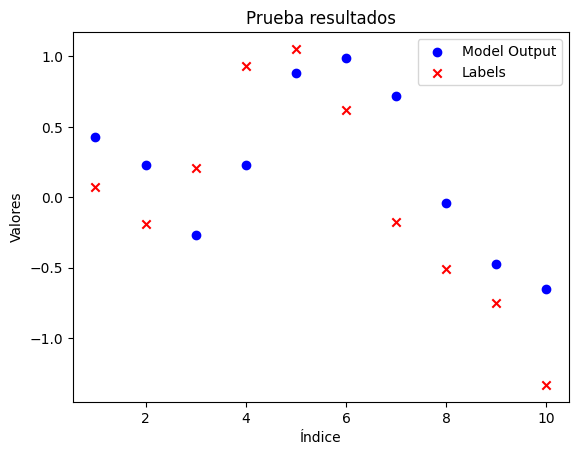

In [45]:
indice = np.arange(1, 11)
plt.scatter(indice, output[37972:37982], label='Model Output', color='blue', marker='o')
plt.scatter(indice, test_labels.values[37972:37982], label='Labels', color='red', marker='x')
# Agregar etiquetas al gráfico
plt.xlabel('Índice')
plt.ylabel('Valores')
plt.title('Prueba resultados')

# Agregar una leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

In [ ]:
output[0:10]

In [ ]:
print(test_labels.values[0:10])

In [103]:
### Defines all the functions used in the fake data testing ###

#Function to test model with added noise to a set column. Said column and noise factor are to be determined by user
def noisy_test(model, test_features, test_labels, noise_factor=0.1, column_to_modify='past_ppna'):
    
    # Generate fake data with noise added to a specific column
    noisy_test_features = test_features.copy()
    noisy_test_features[column_to_modify] = noisy_test_features[column_to_modify] + noise_factor * np.random.randn(len(noisy_test_features[column_to_modify]))

    # Testing with noisy
    print("Entrenamiento del modelo con ruido en", column_to_modify)
    fake_loss = model.evaluate(noisy_test_features, test_labels)
    return fake_loss

#Function to test model with all random values
def all_rand_test(model, test_features, test_labels):
    
    # Generate fake data for all features
    random_test_features = [
        np.random.rand(len(test_features['date'])),  # 'date'
        np.random.rand(len(test_features['latitude'])),  # 'latitude'
        np.random.rand(len(test_features['longitude'])),  # 'longitude'
        np.random.rand(len(test_features['past_ppna']), SEQUENCE_LEN, 1),  # 'past_ppna'
        np.random.rand(len(test_features['precipitation'])),  # 'precipitation'
        np.random.rand(len(test_features['temperature']))  # 'temperature'
    ]

    print("Entrenamiento del modelo con datos aleatorios")
    fake_loss = model.evaluate(random_test_features, test_labels)
    return fake_loss


def permutation_test(model, test_features, test_labels, column_to_permute):

    # Generate fake data with permuted values in a specific column
    permuted_test_features = test_features.copy()
    permuted_test_features[column_to_permute] = np.random.permutation(permuted_test_features[column_to_permute])

    # Convert to Pandas Series (assuming column_to_permute is a single column)
    permuted_test_features[column_to_permute] = pd.Series(permuted_test_features[column_to_permute])

    # Testing with permuted data
    print("Entrenamiento del modelo con permutación en", column_to_permute)
    fake_loss = model.evaluate(permuted_test_features, test_labels)
    
    return fake_loss

def deletion_test(mock_model, train_features, train_labels, test_features, test_labels, val_features, val_labels, deleted_column, epochs=1, batch_size=64):
    # Copia de seguridad de la columna a eliminar
    deleted_features_train = train_features.copy()
    deleted_features_test = test_features.copy()

    # Eliminar temporalmente la columna
    deleted_features_train[deleted_column] = np.nan
    deleted_features_test[deleted_column] = np.nan

    # Entrenar el modelo con la columna eliminada
    history = mock_model.fit(
        deleted_features_train, train_labels.values,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(val_features, val_labels.values) 
    )

    # Evaluar el modelo con la columna restaurada
    fake_loss = mock_model.evaluate(deleted_features_test, test_labels)
    print(f"Pérdida en el conjunto de prueba con {deleted_column} restaurada:", fake_loss)

    return fake_loss

mock_model = keras.models.clone_model(model)
mock_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'accuracy'])
deletion_test(mock_model, train_features, train_labels, test_features, test_labels, val_features, val_labels, 'past_ppna')



ValueError: Failed to find data adapter that can handle input: (<class 'dict'> containing {"<class 'str'>"} keys and {"<class 'pandas.core.series.Series'>", "<class 'float'>"} values), <class 'numpy.ndarray'>

In [90]:
### Function to test if the model works with fake data so as to test if there is data leakage in training ### 
def test_with_fake_data(model, test_features, test_labels, column_to_permute, noise_factor=0.1, column_to_modify = 'past_ppna'):
    # Testing with actual data
    print("Entrenamiento del modelo original")
    original_loss = model.evaluate(test_features, test_labels)



    # Ejemplo 3: Eliminar una característica (por ejemplo, 'longitude')
    #fake_test_features.pop('longitude')

    
   
    # Calls every function to test the model in various scenarios
    noisy_fake_loss = noisy_test(model, test_features, test_labels, noise_factor, column_to_modify)
    random_fake_loss = all_rand_test(model, test_features, test_labels)
    permuted_fake_loss = permutation_test(model, test_features, test_labels, column_to_permute)
    print("Pérdida con datos originales [loss, MAE, accuracy]:", original_loss)    
    print("Pérdida con datos con ruido [loss, MAE, accuracy]:", noisy_fake_loss)
    print("Pérdida con datos aleatorios  [loss, MAE, accuracy]:", random_fake_loss)
    print("Pérdida con datos permutados [loss, MAE, accuracy]:", permuted_fake_loss)

    loss_vector = [noisy_fake_loss, random_fake_loss, permuted_fake_loss]
    return loss_vector


fake_loss = []
fake_loss = test_with_fake_data(model, test_features, test_labels, column_to_permute = 'past_ppna', column_to_modify='past_ppna', noise_factor=0.1)

Entrenamiento del modelo con ruido en past_ppna


5822/5822 [==============================] - 24s 4ms/step - loss: 0.6777 - mae: 0.6918 - accuracy: 0.0000e+00
Entrenamiento del modelo con datos aleatorios
5822/5822 [==============================] - 60s 10ms/step - loss: 4.0833 - mae: 1.7678 - accuracy: 0.0000e+00
Entrenamiento del modelo con permutación en past_ppna
5822/5822 [==============================] - 33s 6ms/step - loss: 1.0981 - mae: 0.8912 - accuracy: 0.0000e+00
Pérdida con datos permutados [loss, MAE, accuracy]: [1.0981239080429077, 0.8911554217338562, 0.0]


In [91]:
print(fake_loss)

[[0.6776644587516785, 0.6917699575424194, 0.0], [4.0833024978637695, 1.7677500247955322, 0.0], [1.0981239080429077, 0.8911554217338562, 0.0]]


<h2>K FOLD INFO</h2>

https://www.kaggle.com/code/satishgunjal/tutorial-k-fold-cross-validation

In [ ]:
### Function to make a cross validation (divides the df in subgroups and test against eachother) ###

# DOESNT WORK #

def cross_validation(model, train_features, train_labels, num_splits=5, epochs=10, batch_size=32):
    kf = KFold(n_splits=num_splits)

    mse_scores = []
    for train_index, val_index in kf.split(train_features):
        x_train = {
            'date': train_features['date'][train_index],
            'latitude': train_features['latitude'][train_index],
            'longitude': train_features['longitude'][train_index],
            'ppna': train_features['ppna'][train_index],
            'precipitation': train_features['precipitation'][train_index],
            'temperature': train_features['temperature'][train_index]
        }
        y_train = train_labels[train_index]

        x_val = {
            'date': train_features['date'][val_index],
            'latitude': train_features['latitude'][val_index],
            'longitude': train_features['longitude'][val_index],
            'ppna': train_features['ppna'][val_index],
            'precipitation': train_features['precipitation'][val_index],
            'temperature': train_features['temperature'][val_index]
        }
        y_val = train_labels[val_index]

        model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
        model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

        val_predictions = model.predict(x_val)
        mse = np.mean(np.square(val_predictions - y_val))
        mse_scores.append(mse)

    mean_mse = np.mean(mse_scores)
    print(f"Mean MSE across {num_splits} folds: {mean_mse}")
    return mean_mse

#Transforms data into numpy arrays to be able to use kfold
train_features_np = np.array(list(train_features.values()))
train_labels_np = train_labels.to_numpy()

mean_mse = cross_validation(model, train_features_np, train_labels_np, num_splits=5, epochs=10, batch_size=32)

In [ ]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                 train_df=train_df, val_df=val_df, test_df=test_df,
                 label_columns=None):
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

def make_dataset(data, window_size, shift, stride=1):
    windows = []
    labels = []

    start_index = 0
    while (start_index + window_size) <= len(data):
        window = data[start_index:start_index + window_size]
        windows.append(window)

        label_index = start_index + window_size + shift - 1
        labels.append(data[label_index])

        start_index += stride

    return np.array(windows), np.array(labels)

# Define parámetros para las ventanas
input_width = 24  # Cantidad de pasos temporales de entrada
label_width = 1  # Cantidad de pasos temporales a predecir
shift = 1  # Paso de tiempo entre muestras

# Crear instancias de WindowGenerator
window_generator = WindowGenerator(
    input_width=input_width, label_width=label_width, shift=shift,
    train_df=train_normalized.iloc[:len(train_normalized)],
    val_df=val_normalized.iloc[:len(val_normalized)],
    test_df=test_normalized.iloc[:len(test_normalized)],
    label_columns=['ppna']
)


# Obtener datos para entrenamiento, validación y prueba
train_windows, train_labels = make_dataset(window_generator.train_df['ppna'], window_generator.total_window_size, shift)
val_windows, val_labels = make_dataset(window_generator.val_df['ppna'], window_generator.total_window_size, shift)
test_windows, test_labels = make_dataset(window_generator.test_df['ppna'], window_generator.total_window_size, shift)

# Verificar las formas de los conjuntos de datos
print(f"Train data shape: {train_windows.shape}")
print(f"Validation data shape: {val_windows.shape}")
print(f"Test data shape: {test_windows.shape}")
